# Setup

In [1]:
!pip install -qU langchain
!pip install -qU langchain-google-genai
!pip install -qU langchain-huggingface
!pip install -qU langchain-qdrant
!pip install -qU langchain-community
!pip install -qU langgraph
!pip install fastembed
!pip install datasets
# !pip install -U "fsspec[http]==2024.10.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 65.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.17 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.

# Code

In this assignment, you will need to set up and use
1. LangSmith to monitor your agent.
2. Use hybrid search to improve your retriever
3. Use a reranker to improve your search result.



## TODO 0: Set up LangSmith

Create a LangSmith account and set up tracing for this assignment. https://www.smith.langchain.com/.

No need to configure, just add your LangSmith API key.

In [2]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')

## Components

We will be using Gemini as our LLM. Feel free to try out others if you want.

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

For our sentence embeddings, we will use [ModernBERT](https://arxiv.org/abs/2412.13663) trained by Alibaba as it is small and performant.

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings

model_kwargs = {'trust_remote_code': True}
embeddings = HuggingFaceEmbeddings(model_name="Alibaba-NLP/gte-modernbert-base",model_kwargs=model_kwargs)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/298M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

Likewise, the reranker is also based on the ModernBERT trained by Alibaba.

In [5]:
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CrossEncoderReranker
from langchain_community.cross_encoders import HuggingFaceCrossEncoder

model = HuggingFaceCrossEncoder(model_name="Alibaba-NLP/gte-reranker-modernbert-base")

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/598M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

For our dataset, we will be using SQuAD v2 dataset.

In [6]:
import datasets

ds = datasets.load_dataset("rajpurkar/squad_v2", split="validation")

README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

## Indexing

In [7]:
from langchain_core.documents import Document

In [8]:
all_docs = [Document(text) for text in  list(set(ds["context"]))]
print(len(all_docs))

1204


In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(all_docs)

print(f"Split wiki abstract into {len(all_splits)} sub-documents.")

Split wiki abstract into 1222 sub-documents.


## TODO 1: Hybrid Search
Embed your documents in a vector database that supports hybrid search. Also set the retrieval mode to hybrid search. Use BM25 as the lexical search.

Hint: read more on `QdrantVectorStore` [here](https://python.langchain.com/api_reference/qdrant/qdrant/langchain_qdrant.qdrant.QdrantVectorStore.html#langchain_qdrant.qdrant.QdrantVectorStore). (You can use any vector DB that can do hybrid search)

In [10]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="demo_collection",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name="demo_collection",
    embedding=embeddings,
)

vector_store.add_documents(all_splits)

W0406 11:48:53.843000 1672 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


['ef58023d0e0b461fb269e5af612651d9',
 '3da3d6cd1b0647f4a66b7af1bad79206',
 'a7b7ef09c3f14c19a5e33672d23054e6',
 '7e380bf748594e84ba76ad2be0f2310a',
 'c1682d1bea5047df9ad2867713a91edf',
 'e1b596502bcd43d7ac0a9a0d752c1688',
 '5d91d7c0f6014df38060bf21f6946408',
 'd4bcc86e0e074d7497db5145155e9043',
 '1616b558f0c54c8795ebf1cb2cf71b40',
 '205258bd5dd949de93f8ee2cc77576ab',
 '233783719e474d10a3568c0c41ce6312',
 '94ce852b21cb4f02ae5702036155a9d9',
 'a5046a5ea6b8459c95837f7f109efbca',
 '7ddeb6b36dc84fb79322b6e4cb805e03',
 '0874a1411b3947dfa30348afc5e96fe0',
 '0fadbc4eb2be4e87a13b9930a391a103',
 '7dea7efc4b37449f9f0a136c2e310b08',
 '3d4fbfcabc1741e098fadf96885c7a2e',
 'dac12529ddb044279ef2fbf3939ef55f',
 'dba3961bfb2243dd8b356c440cdfe32f',
 '1cb69f35b3b549e6bb6bf04d28674b38',
 '68114e78cec34d2982910b6e10e551be',
 '83bba2c0c4614ab2ac10068fc684b9d7',
 '81f04274bbb94fd5bc9d26fd2565f2d2',
 'a48dc314808f403fa231f276cb40cbe1',
 '23b483b4950e4ac697ad865a26c295c2',
 'b1669bfd5ecf4788b0fc2a8407d0cfb0',
 

## TODO 2: Reranking

Create two retrievers.
1. A normal retriever without a reranker. Set the `top_k` to 20.
2. A retriever with a reranker. Set the `top_k` of the reranker to 3.


In [11]:
retriever_normal = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 20},
)

retriever_mmr = vector_store.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 20, "fetch_k": 20, "lambda_mult": 0.5},
)

reranker = CrossEncoderReranker(model=model)
def reranked_retriever(query):
    retrieved_docs = retriever_mmr.invoke(query)

    reranked_docs = reranker.compress_documents(retrieved_docs, query=query)[:3]

    return reranked_docs


Take a subset of the dataset to evaluate the MRR of the retrievers.

In [12]:
sample = ds.take(1000)
print(sample)

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 1000
})


## TODO 3: Retrieval Evaluation

Calculate the MRR of the two retrievers based on the top 3 returned by each retriever.

**For the vanilla retriever (no reranker), take only the top-3 to evaluate the MRR and ignore the rest.**

In [13]:
from tqdm import tqdm

no_rerank = no_rerank_failures = 0
limit = -1
count = 0

for row in tqdm(sample):
    query = row["question"]
    context = row["context"]

    res_mmr = retriever_mmr.invoke(query)
    found = False
    for i in range(3):
        doc_content = res_mmr[i].page_content
        if doc_content == context:
            no_rerank += 1/(i+1)
            found = True
            break
    if not found:
        print(f"Query {count}: Failed to find relevant doc in top 3 results")
        no_rerank_failures += 1

    count += 1
    if limit != -1 and count == limit:
        break

rerank = rerank_failures = 0
index = 0
limit = -1

for index in tqdm(range(len(sample))):
    row = sample[index]
    query = row["question"]
    context = row["context"]

    res_reranked = reranked_retriever(query)
    found = False
    for i in range(3):
        doc_content = res_reranked[i].page_content
        if doc_content == context:
            rerank += 1/(i+1)
            found = True
            break
    if not found:
        print(f"Query {index}: Failed to find relevant doc in top 3 results")
        rerank_failures += 1

    index += 1
    if limit != -1 and index == limit:
        break


  0%|          | 4/1000 [00:00<02:09,  7.68it/s]

Query 2: Failed to find relevant doc in top 3 results


  1%|          | 8/1000 [00:01<01:56,  8.54it/s]

Query 6: Failed to find relevant doc in top 3 results
Query 7: Failed to find relevant doc in top 3 results


  1%|          | 10/1000 [00:01<02:01,  8.18it/s]

Query 8: Failed to find relevant doc in top 3 results
Query 9: Failed to find relevant doc in top 3 results


  1%|          | 12/1000 [00:01<01:58,  8.36it/s]

Query 10: Failed to find relevant doc in top 3 results
Query 11: Failed to find relevant doc in top 3 results


  2%|▏         | 16/1000 [00:01<01:58,  8.33it/s]

Query 14: Failed to find relevant doc in top 3 results
Query 15: Failed to find relevant doc in top 3 results


  2%|▏         | 17/1000 [00:02<02:14,  7.33it/s]

Query 16: Failed to find relevant doc in top 3 results


  3%|▎         | 26/1000 [00:03<02:56,  5.53it/s]

Query 24: Failed to find relevant doc in top 3 results


  3%|▎         | 29/1000 [00:04<02:47,  5.81it/s]

Query 27: Failed to find relevant doc in top 3 results


  3%|▎         | 33/1000 [00:04<02:16,  7.07it/s]

Query 31: Failed to find relevant doc in top 3 results
Query 32: Failed to find relevant doc in top 3 results


  5%|▌         | 52/1000 [00:07<01:52,  8.46it/s]

Query 50: Failed to find relevant doc in top 3 results


  5%|▌         | 54/1000 [00:07<01:53,  8.35it/s]

Query 52: Failed to find relevant doc in top 3 results


  6%|▌         | 58/1000 [00:07<01:49,  8.60it/s]

Query 56: Failed to find relevant doc in top 3 results


  6%|▋         | 63/1000 [00:08<01:54,  8.18it/s]

Query 61: Failed to find relevant doc in top 3 results


  6%|▋         | 65/1000 [00:08<01:56,  8.06it/s]

Query 63: Failed to find relevant doc in top 3 results
Query 64: Failed to find relevant doc in top 3 results


  7%|▋         | 68/1000 [00:09<01:49,  8.54it/s]

Query 66: Failed to find relevant doc in top 3 results


  7%|▋         | 71/1000 [00:09<01:48,  8.56it/s]

Query 69: Failed to find relevant doc in top 3 results


  7%|▋         | 73/1000 [00:09<01:48,  8.57it/s]

Query 71: Failed to find relevant doc in top 3 results
Query 72: Failed to find relevant doc in top 3 results


  8%|▊         | 76/1000 [00:10<01:46,  8.71it/s]

Query 74: Failed to find relevant doc in top 3 results
Query 75: Failed to find relevant doc in top 3 results


  8%|▊         | 79/1000 [00:10<01:46,  8.62it/s]

Query 77: Failed to find relevant doc in top 3 results


  8%|▊         | 82/1000 [00:10<01:49,  8.37it/s]

Query 80: Failed to find relevant doc in top 3 results


 10%|█         | 100/1000 [00:12<01:48,  8.31it/s]

Query 98: Failed to find relevant doc in top 3 results


 10%|█         | 102/1000 [00:13<01:46,  8.45it/s]

Query 100: Failed to find relevant doc in top 3 results


 10%|█         | 104/1000 [00:13<01:45,  8.48it/s]

Query 102: Failed to find relevant doc in top 3 results


 11%|█         | 106/1000 [00:13<01:43,  8.66it/s]

Query 104: Failed to find relevant doc in top 3 results


 11%|█         | 112/1000 [00:14<01:42,  8.67it/s]

Query 110: Failed to find relevant doc in top 3 results


 12%|█▏        | 115/1000 [00:14<01:44,  8.45it/s]

Query 113: Failed to find relevant doc in top 3 results


 13%|█▎        | 130/1000 [00:17<02:10,  6.68it/s]

Query 128: Failed to find relevant doc in top 3 results


 13%|█▎        | 132/1000 [00:17<01:56,  7.43it/s]

Query 130: Failed to find relevant doc in top 3 results
Query 131: Failed to find relevant doc in top 3 results


 14%|█▍        | 139/1000 [00:18<01:44,  8.24it/s]

Query 137: Failed to find relevant doc in top 3 results


 15%|█▍        | 148/1000 [00:19<01:47,  7.92it/s]

Query 146: Failed to find relevant doc in top 3 results
Query 147: Failed to find relevant doc in top 3 results


 15%|█▌        | 152/1000 [00:19<01:43,  8.19it/s]

Query 150: Failed to find relevant doc in top 3 results


 16%|█▌        | 158/1000 [00:20<01:39,  8.48it/s]

Query 156: Failed to find relevant doc in top 3 results


 16%|█▋        | 163/1000 [00:21<01:37,  8.59it/s]

Query 161: Failed to find relevant doc in top 3 results


 16%|█▋        | 165/1000 [00:21<01:37,  8.53it/s]

Query 163: Failed to find relevant doc in top 3 results
Query 164: Failed to find relevant doc in top 3 results


 17%|█▋        | 172/1000 [00:22<01:43,  8.02it/s]

Query 170: Failed to find relevant doc in top 3 results
Query 171: Failed to find relevant doc in top 3 results


 18%|█▊        | 176/1000 [00:22<01:35,  8.59it/s]

Query 174: Failed to find relevant doc in top 3 results


 19%|█▊        | 187/1000 [00:24<01:34,  8.58it/s]

Query 185: Failed to find relevant doc in top 3 results


 19%|█▉        | 190/1000 [00:24<01:37,  8.35it/s]

Query 188: Failed to find relevant doc in top 3 results
Query 189: Failed to find relevant doc in top 3 results


 20%|█▉        | 199/1000 [00:25<01:36,  8.28it/s]

Query 197: Failed to find relevant doc in top 3 results


 20%|██        | 203/1000 [00:26<01:36,  8.28it/s]

Query 201: Failed to find relevant doc in top 3 results
Query 202: Failed to find relevant doc in top 3 results


 21%|██        | 209/1000 [00:26<01:31,  8.62it/s]

Query 207: Failed to find relevant doc in top 3 results


 22%|██▏       | 215/1000 [00:27<02:06,  6.21it/s]

Query 213: Failed to find relevant doc in top 3 results
Query 214: Failed to find relevant doc in top 3 results


 22%|██▏       | 217/1000 [00:28<02:17,  5.71it/s]

Query 215: Failed to find relevant doc in top 3 results


 22%|██▏       | 220/1000 [00:28<02:25,  5.34it/s]

Query 218: Failed to find relevant doc in top 3 results


 22%|██▏       | 224/1000 [00:29<02:20,  5.53it/s]

Query 223: Failed to find relevant doc in top 3 results


 23%|██▎       | 227/1000 [00:29<01:57,  6.58it/s]

Query 225: Failed to find relevant doc in top 3 results
Query 226: Failed to find relevant doc in top 3 results


 23%|██▎       | 232/1000 [00:30<01:35,  8.08it/s]

Query 230: Failed to find relevant doc in top 3 results


 25%|██▍       | 246/1000 [00:31<01:28,  8.50it/s]

Query 244: Failed to find relevant doc in top 3 results


 25%|██▍       | 249/1000 [00:32<01:28,  8.51it/s]

Query 247: Failed to find relevant doc in top 3 results


 25%|██▌       | 251/1000 [00:32<01:29,  8.33it/s]

Query 249: Failed to find relevant doc in top 3 results


 25%|██▌       | 253/1000 [00:32<01:30,  8.30it/s]

Query 251: Failed to find relevant doc in top 3 results


 26%|██▌       | 261/1000 [00:33<01:26,  8.50it/s]

Query 259: Failed to find relevant doc in top 3 results


 26%|██▋       | 263/1000 [00:33<01:25,  8.61it/s]

Query 261: Failed to find relevant doc in top 3 results
Query 262: Failed to find relevant doc in top 3 results


 27%|██▋       | 268/1000 [00:34<01:26,  8.48it/s]

Query 266: Failed to find relevant doc in top 3 results
Query 267: Failed to find relevant doc in top 3 results


 27%|██▋       | 273/1000 [00:35<01:24,  8.61it/s]

Query 271: Failed to find relevant doc in top 3 results


 29%|██▊       | 286/1000 [00:36<01:28,  8.03it/s]

Query 284: Failed to find relevant doc in top 3 results
Query 285: Failed to find relevant doc in top 3 results


 29%|██▉       | 290/1000 [00:37<01:24,  8.40it/s]

Query 288: Failed to find relevant doc in top 3 results


 30%|██▉       | 296/1000 [00:37<01:24,  8.30it/s]

Query 294: Failed to find relevant doc in top 3 results
Query 295: Failed to find relevant doc in top 3 results


 30%|██▉       | 298/1000 [00:38<01:22,  8.52it/s]

Query 296: Failed to find relevant doc in top 3 results


 30%|███       | 301/1000 [00:38<01:21,  8.61it/s]

Query 299: Failed to find relevant doc in top 3 results
Query 300: Failed to find relevant doc in top 3 results


 30%|███       | 303/1000 [00:38<01:23,  8.36it/s]

Query 301: Failed to find relevant doc in top 3 results


 30%|███       | 305/1000 [00:38<01:21,  8.52it/s]

Query 303: Failed to find relevant doc in top 3 results
Query 304: Failed to find relevant doc in top 3 results


 31%|███       | 309/1000 [00:39<01:19,  8.64it/s]

Query 307: Failed to find relevant doc in top 3 results


 31%|███       | 312/1000 [00:39<01:37,  7.03it/s]

Query 310: Failed to find relevant doc in top 3 results


 31%|███▏      | 314/1000 [00:40<01:56,  5.87it/s]

Query 312: Failed to find relevant doc in top 3 results
Query 313: Failed to find relevant doc in top 3 results


 32%|███▏      | 320/1000 [00:41<01:56,  5.85it/s]

Query 319: Failed to find relevant doc in top 3 results


 32%|███▏      | 322/1000 [00:41<02:04,  5.43it/s]

Query 320: Failed to find relevant doc in top 3 results
Query 321: Failed to find relevant doc in top 3 results


 32%|███▏      | 324/1000 [00:42<02:02,  5.51it/s]

Query 322: Failed to find relevant doc in top 3 results
Query 323: Failed to find relevant doc in top 3 results


 33%|███▎      | 330/1000 [00:42<01:25,  7.84it/s]

Query 328: Failed to find relevant doc in top 3 results
Query 329: Failed to find relevant doc in top 3 results


 33%|███▎      | 332/1000 [00:43<01:25,  7.86it/s]

Query 330: Failed to find relevant doc in top 3 results
Query 331: Failed to find relevant doc in top 3 results


 33%|███▎      | 334/1000 [00:43<01:22,  8.08it/s]

Query 332: Failed to find relevant doc in top 3 results


 35%|███▌      | 353/1000 [00:45<01:19,  8.18it/s]

Query 351: Failed to find relevant doc in top 3 results


 36%|███▌      | 355/1000 [00:45<01:16,  8.40it/s]

Query 353: Failed to find relevant doc in top 3 results


 36%|███▌      | 359/1000 [00:46<01:16,  8.33it/s]

Query 357: Failed to find relevant doc in top 3 results


 36%|███▌      | 361/1000 [00:46<01:15,  8.43it/s]

Query 359: Failed to find relevant doc in top 3 results


 36%|███▋      | 363/1000 [00:46<01:14,  8.53it/s]

Query 361: Failed to find relevant doc in top 3 results


 36%|███▋      | 365/1000 [00:47<01:14,  8.49it/s]

Query 363: Failed to find relevant doc in top 3 results


 37%|███▋      | 372/1000 [00:47<01:11,  8.79it/s]

Query 370: Failed to find relevant doc in top 3 results


 38%|███▊      | 379/1000 [00:48<01:12,  8.54it/s]

Query 377: Failed to find relevant doc in top 3 results


 38%|███▊      | 382/1000 [00:49<01:12,  8.47it/s]

Query 380: Failed to find relevant doc in top 3 results
Query 381: Failed to find relevant doc in top 3 results


 38%|███▊      | 384/1000 [00:49<01:13,  8.37it/s]

Query 382: Failed to find relevant doc in top 3 results


 39%|███▉      | 391/1000 [00:50<01:11,  8.46it/s]

Query 389: Failed to find relevant doc in top 3 results


 39%|███▉      | 394/1000 [00:50<01:12,  8.35it/s]

Query 392: Failed to find relevant doc in top 3 results


 40%|███▉      | 399/1000 [00:51<01:10,  8.53it/s]

Query 397: Failed to find relevant doc in top 3 results
Query 398: Failed to find relevant doc in top 3 results


 42%|████▏     | 418/1000 [00:53<01:40,  5.77it/s]

Query 416: Failed to find relevant doc in top 3 results


 42%|████▏     | 424/1000 [00:54<01:39,  5.77it/s]

Query 422: Failed to find relevant doc in top 3 results


 43%|████▎     | 426/1000 [00:55<01:23,  6.85it/s]

Query 424: Failed to find relevant doc in top 3 results


 43%|████▎     | 429/1000 [00:55<01:13,  7.76it/s]

Query 427: Failed to find relevant doc in top 3 results


 43%|████▎     | 431/1000 [00:55<01:10,  8.08it/s]

Query 429: Failed to find relevant doc in top 3 results


 43%|████▎     | 433/1000 [00:55<01:07,  8.35it/s]

Query 431: Failed to find relevant doc in top 3 results
Query 432: Failed to find relevant doc in top 3 results


 45%|████▍     | 446/1000 [00:57<01:06,  8.38it/s]

Query 444: Failed to find relevant doc in top 3 results


 45%|████▌     | 451/1000 [00:58<01:06,  8.31it/s]

Query 449: Failed to find relevant doc in top 3 results


 46%|████▌     | 461/1000 [00:59<01:02,  8.62it/s]

Query 459: Failed to find relevant doc in top 3 results
Query 460: Failed to find relevant doc in top 3 results


 47%|████▋     | 467/1000 [01:00<01:02,  8.49it/s]

Query 465: Failed to find relevant doc in top 3 results


 48%|████▊     | 482/1000 [01:01<01:03,  8.19it/s]

Query 480: Failed to find relevant doc in top 3 results


 49%|████▊     | 486/1000 [01:02<01:00,  8.51it/s]

Query 484: Failed to find relevant doc in top 3 results


 49%|████▉     | 489/1000 [01:02<01:01,  8.29it/s]

Query 487: Failed to find relevant doc in top 3 results


 49%|████▉     | 494/1000 [01:03<01:00,  8.38it/s]

Query 492: Failed to find relevant doc in top 3 results
Query 493: Failed to find relevant doc in top 3 results


 50%|████▉     | 496/1000 [01:03<00:59,  8.45it/s]

Query 494: Failed to find relevant doc in top 3 results
Query 495: Failed to find relevant doc in top 3 results


 50%|█████     | 503/1000 [01:04<00:59,  8.32it/s]

Query 501: Failed to find relevant doc in top 3 results


 50%|█████     | 505/1000 [01:04<00:59,  8.32it/s]

Query 503: Failed to find relevant doc in top 3 results


 52%|█████▏    | 520/1000 [01:07<01:25,  5.64it/s]

Query 518: Failed to find relevant doc in top 3 results


 53%|█████▎    | 530/1000 [01:08<00:57,  8.19it/s]

Query 528: Failed to find relevant doc in top 3 results


 54%|█████▎    | 537/1000 [01:09<00:53,  8.61it/s]

Query 535: Failed to find relevant doc in top 3 results


 54%|█████▍    | 540/1000 [01:09<00:52,  8.70it/s]

Query 538: Failed to find relevant doc in top 3 results


 55%|█████▍    | 546/1000 [01:10<00:52,  8.72it/s]

Query 544: Failed to find relevant doc in top 3 results


 56%|█████▌    | 555/1000 [01:11<00:52,  8.47it/s]

Query 553: Failed to find relevant doc in top 3 results
Query 554: Failed to find relevant doc in top 3 results


 58%|█████▊    | 583/1000 [01:14<00:49,  8.36it/s]

Query 581: Failed to find relevant doc in top 3 results


 59%|█████▉    | 588/1000 [01:15<00:51,  8.03it/s]

Query 586: Failed to find relevant doc in top 3 results
Query 587: Failed to find relevant doc in top 3 results


 59%|█████▉    | 590/1000 [01:15<00:50,  8.19it/s]

Query 588: Failed to find relevant doc in top 3 results
Query 589: Failed to find relevant doc in top 3 results


 59%|█████▉    | 594/1000 [01:16<00:49,  8.18it/s]

Query 592: Failed to find relevant doc in top 3 results
Query 593: Failed to find relevant doc in top 3 results


 61%|██████    | 611/1000 [01:18<01:10,  5.52it/s]

Query 610: Failed to find relevant doc in top 3 results


 63%|██████▎   | 629/1000 [01:21<00:43,  8.46it/s]

Query 627: Failed to find relevant doc in top 3 results


 63%|██████▎   | 632/1000 [01:21<00:43,  8.40it/s]

Query 630: Failed to find relevant doc in top 3 results


 64%|██████▎   | 635/1000 [01:21<00:43,  8.43it/s]

Query 633: Failed to find relevant doc in top 3 results


 64%|██████▍   | 644/1000 [01:23<00:42,  8.46it/s]

Query 642: Failed to find relevant doc in top 3 results


 65%|██████▍   | 647/1000 [01:23<00:40,  8.69it/s]

Query 645: Failed to find relevant doc in top 3 results
Query 646: Failed to find relevant doc in top 3 results


 65%|██████▌   | 650/1000 [01:23<00:41,  8.52it/s]

Query 648: Failed to find relevant doc in top 3 results
Query 649: Failed to find relevant doc in top 3 results


 65%|██████▌   | 652/1000 [01:24<00:41,  8.33it/s]

Query 650: Failed to find relevant doc in top 3 results
Query 651: Failed to find relevant doc in top 3 results


 66%|██████▋   | 664/1000 [01:25<00:40,  8.36it/s]

Query 662: Failed to find relevant doc in top 3 results
Query 663: Failed to find relevant doc in top 3 results


 67%|██████▋   | 667/1000 [01:25<00:39,  8.35it/s]

Query 665: Failed to find relevant doc in top 3 results


 67%|██████▋   | 673/1000 [01:26<00:38,  8.51it/s]

Query 671: Failed to find relevant doc in top 3 results


 68%|██████▊   | 678/1000 [01:27<00:38,  8.45it/s]

Query 676: Failed to find relevant doc in top 3 results


 68%|██████▊   | 682/1000 [01:27<00:39,  8.05it/s]

Query 680: Failed to find relevant doc in top 3 results


 68%|██████▊   | 684/1000 [01:27<00:38,  8.29it/s]

Query 682: Failed to find relevant doc in top 3 results


 69%|██████▉   | 690/1000 [01:28<00:36,  8.43it/s]

Query 688: Failed to find relevant doc in top 3 results


 71%|███████   | 710/1000 [01:31<00:51,  5.67it/s]

Query 708: Failed to find relevant doc in top 3 results


 71%|███████▏  | 714/1000 [01:32<00:51,  5.52it/s]

Query 713: Failed to find relevant doc in top 3 results


 72%|███████▏  | 719/1000 [01:32<00:38,  7.26it/s]

Query 717: Failed to find relevant doc in top 3 results
Query 718: Failed to find relevant doc in top 3 results


 72%|███████▏  | 721/1000 [01:33<00:35,  7.77it/s]

Query 719: Failed to find relevant doc in top 3 results
Query 720: Failed to find relevant doc in top 3 results


 73%|███████▎  | 727/1000 [01:33<00:34,  7.98it/s]

Query 725: Failed to find relevant doc in top 3 results


 74%|███████▍  | 742/1000 [01:35<00:30,  8.53it/s]

Query 740: Failed to find relevant doc in top 3 results


 75%|███████▌  | 751/1000 [01:36<00:28,  8.64it/s]

Query 749: Failed to find relevant doc in top 3 results


 76%|███████▌  | 758/1000 [01:37<00:28,  8.53it/s]

Query 756: Failed to find relevant doc in top 3 results


 76%|███████▌  | 761/1000 [01:38<00:27,  8.69it/s]

Query 759: Failed to find relevant doc in top 3 results
Query 760: Failed to find relevant doc in top 3 results


 77%|███████▋  | 767/1000 [01:38<00:27,  8.60it/s]

Query 765: Failed to find relevant doc in top 3 results


 77%|███████▋  | 769/1000 [01:38<00:26,  8.68it/s]

Query 767: Failed to find relevant doc in top 3 results


 77%|███████▋  | 771/1000 [01:39<00:26,  8.60it/s]

Query 769: Failed to find relevant doc in top 3 results


 77%|███████▋  | 773/1000 [01:39<00:26,  8.54it/s]

Query 771: Failed to find relevant doc in top 3 results


 78%|███████▊  | 778/1000 [01:40<00:26,  8.47it/s]

Query 776: Failed to find relevant doc in top 3 results


 78%|███████▊  | 782/1000 [01:40<00:25,  8.46it/s]

Query 780: Failed to find relevant doc in top 3 results


 80%|███████▉  | 799/1000 [01:42<00:26,  7.62it/s]

Query 797: Failed to find relevant doc in top 3 results


 80%|████████  | 805/1000 [01:43<00:33,  5.78it/s]

Query 803: Failed to find relevant doc in top 3 results


 81%|████████  | 808/1000 [01:44<00:33,  5.79it/s]

Query 806: Failed to find relevant doc in top 3 results


 81%|████████  | 809/1000 [01:44<00:36,  5.30it/s]

Query 808: Failed to find relevant doc in top 3 results


 81%|████████  | 811/1000 [01:44<00:33,  5.64it/s]

Query 809: Failed to find relevant doc in top 3 results


 81%|████████▏ | 814/1000 [01:45<00:32,  5.71it/s]

Query 812: Failed to find relevant doc in top 3 results
Query 813: Failed to find relevant doc in top 3 results


 82%|████████▏ | 816/1000 [01:45<00:27,  6.65it/s]

Query 814: Failed to find relevant doc in top 3 results


 83%|████████▎ | 827/1000 [01:46<00:19,  8.75it/s]

Query 825: Failed to find relevant doc in top 3 results


 83%|████████▎ | 834/1000 [01:47<00:19,  8.31it/s]

Query 832: Failed to find relevant doc in top 3 results
Query 833: Failed to find relevant doc in top 3 results


 84%|████████▍ | 842/1000 [01:48<00:19,  8.28it/s]

Query 840: Failed to find relevant doc in top 3 results


 84%|████████▍ | 844/1000 [01:48<00:18,  8.42it/s]

Query 842: Failed to find relevant doc in top 3 results


 85%|████████▍ | 846/1000 [01:49<00:18,  8.33it/s]

Query 844: Failed to find relevant doc in top 3 results
Query 845: Failed to find relevant doc in top 3 results


 85%|████████▌ | 853/1000 [01:49<00:18,  8.08it/s]

Query 851: Failed to find relevant doc in top 3 results


 86%|████████▌ | 856/1000 [01:50<00:17,  8.23it/s]

Query 854: Failed to find relevant doc in top 3 results


 86%|████████▌ | 858/1000 [01:50<00:17,  8.30it/s]

Query 856: Failed to find relevant doc in top 3 results
Query 857: Failed to find relevant doc in top 3 results


 88%|████████▊ | 884/1000 [01:53<00:13,  8.49it/s]

Query 882: Failed to find relevant doc in top 3 results


 91%|█████████ | 907/1000 [01:56<00:16,  5.68it/s]

Query 905: Failed to find relevant doc in top 3 results


 91%|█████████ | 911/1000 [01:57<00:15,  5.82it/s]

Query 909: Failed to find relevant doc in top 3 results


 93%|█████████▎| 932/1000 [02:00<00:08,  8.17it/s]

Query 930: Failed to find relevant doc in top 3 results


 94%|█████████▍| 943/1000 [02:01<00:06,  8.38it/s]

Query 941: Failed to find relevant doc in top 3 results
Query 942: Failed to find relevant doc in top 3 results


 94%|█████████▍| 945/1000 [02:01<00:06,  8.41it/s]

Query 943: Failed to find relevant doc in top 3 results


 95%|█████████▌| 953/1000 [02:02<00:05,  8.35it/s]

Query 951: Failed to find relevant doc in top 3 results


 96%|█████████▌| 956/1000 [02:03<00:05,  8.56it/s]

Query 954: Failed to find relevant doc in top 3 results


 96%|█████████▌| 958/1000 [02:03<00:05,  8.37it/s]

Query 956: Failed to find relevant doc in top 3 results


 97%|█████████▋| 968/1000 [02:04<00:03,  8.44it/s]

Query 966: Failed to find relevant doc in top 3 results


 97%|█████████▋| 970/1000 [02:04<00:03,  8.45it/s]

Query 968: Failed to find relevant doc in top 3 results


 98%|█████████▊| 980/1000 [02:05<00:02,  8.45it/s]

Query 978: Failed to find relevant doc in top 3 results
Query 979: Failed to find relevant doc in top 3 results


 99%|█████████▊| 986/1000 [02:06<00:01,  8.58it/s]

Query 984: Failed to find relevant doc in top 3 results


  2%|▏         | 16/1000 [00:09<09:26,  1.74it/s]

Query 15: Failed to find relevant doc in top 3 results


  6%|▌         | 62/1000 [00:39<10:34,  1.48it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 61: Failed to find relevant doc in top 3 results


  7%|▋         | 70/1000 [00:45<10:01,  1.55it/s]

Query 69: Failed to find relevant doc in top 3 results


 10%|█         | 101/1000 [01:05<09:45,  1.53it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 100: Failed to find relevant doc in top 3 results


 11%|█         | 111/1000 [01:12<09:51,  1.50it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 110: Failed to find relevant doc in top 3 results


 16%|█▌        | 157/1000 [01:42<09:46,  1.44it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 156: Failed to find relevant doc in top 3 results


 17%|█▋        | 171/1000 [01:51<09:54,  1.40it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 170: Failed to find relevant doc in top 3 results


 19%|█▊        | 186/1000 [02:00<07:46,  1.75it/s]

Query 185: Failed to find relevant doc in top 3 results


 21%|██        | 208/1000 [02:14<08:42,  1.51it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 207: Failed to find relevant doc in top 3 results


 22%|██▏       | 215/1000 [02:18<07:41,  1.70it/s]

Query 214: Failed to find relevant doc in top 3 results


 22%|██▏       | 216/1000 [02:18<07:36,  1.72it/s]

Query 215: Failed to find relevant doc in top 3 results


 24%|██▍       | 245/1000 [02:35<06:18,  2.00it/s]

Query 244: Failed to find relevant doc in top 3 results


 25%|██▍       | 248/1000 [02:36<06:47,  1.84it/s]

Query 247: Failed to find relevant doc in top 3 results


 26%|██▋       | 263/1000 [02:45<06:39,  1.85it/s]

Query 262: Failed to find relevant doc in top 3 results


 27%|██▋       | 268/1000 [02:47<06:27,  1.89it/s]

Query 267: Failed to find relevant doc in top 3 results


 30%|███       | 301/1000 [03:05<06:37,  1.76it/s]

Query 300: Failed to find relevant doc in top 3 results


 33%|███▎      | 330/1000 [03:21<05:59,  1.87it/s]

Query 329: Failed to find relevant doc in top 3 results


 36%|███▌      | 360/1000 [03:38<06:14,  1.71it/s]

Query 359: Failed to find relevant doc in top 3 results


 36%|███▋      | 364/1000 [03:40<06:28,  1.64it/s]

Query 363: Failed to find relevant doc in top 3 results


 38%|███▊      | 378/1000 [03:48<05:11,  2.00it/s]

Query 377: Failed to find relevant doc in top 3 results


 38%|███▊      | 382/1000 [03:50<05:03,  2.04it/s]

Query 381: Failed to find relevant doc in top 3 results


 41%|████      | 411/1000 [04:07<05:21,  1.83it/s]

Query 410: Failed to find relevant doc in top 3 results


 42%|████▏     | 415/1000 [04:09<05:15,  1.85it/s]

Query 414: Failed to find relevant doc in top 3 results


 48%|████▊     | 481/1000 [04:45<04:40,  1.85it/s]

Query 480: Failed to find relevant doc in top 3 results


 51%|█████     | 511/1000 [05:03<04:41,  1.74it/s]

Query 510: Failed to find relevant doc in top 3 results


 56%|█████▌    | 555/1000 [05:28<04:14,  1.75it/s]

Query 554: Failed to find relevant doc in top 3 results


 59%|█████▉    | 590/1000 [05:48<03:51,  1.77it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 589: Failed to find relevant doc in top 3 results


 59%|█████▉    | 593/1000 [05:49<03:40,  1.85it/s]

Query 592: Failed to find relevant doc in top 3 results


 60%|██████    | 600/1000 [05:53<04:07,  1.62it/s]

Query 599: Failed to find relevant doc in top 3 results


 63%|██████▎   | 631/1000 [06:11<03:34,  1.72it/s]

Query 630: Failed to find relevant doc in top 3 results


 65%|██████▍   | 649/1000 [06:21<03:18,  1.77it/s]

Query 648: Failed to find relevant doc in top 3 results


 65%|██████▌   | 650/1000 [06:21<03:35,  1.63it/s]

Query 649: Failed to find relevant doc in top 3 results


 65%|██████▌   | 651/1000 [06:22<03:30,  1.66it/s]

Query 650: Failed to find relevant doc in top 3 results


 67%|██████▋   | 672/1000 [06:33<03:22,  1.62it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 671: Failed to find relevant doc in top 3 results


 72%|███████▏  | 718/1000 [07:00<02:56,  1.59it/s]

Query 717: Failed to find relevant doc in top 3 results


 72%|███████▏  | 719/1000 [07:01<03:06,  1.51it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 718: Failed to find relevant doc in top 3 results


 73%|███████▎  | 726/1000 [07:05<02:48,  1.63it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 725: Failed to find relevant doc in top 3 results


 76%|███████▌  | 760/1000 [07:24<02:01,  1.97it/s]

Query 759: Failed to find relevant doc in top 3 results


 78%|███████▊  | 777/1000 [07:34<02:09,  1.72it/s]

Query 776: Failed to find relevant doc in top 3 results


 80%|███████▉  | 798/1000 [07:46<02:18,  1.46it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 797: Failed to find relevant doc in top 3 results


 81%|████████  | 810/1000 [07:53<01:45,  1.80it/s]

Query 809: Failed to find relevant doc in top 3 results


 81%|████████▏ | 814/1000 [07:55<01:36,  1.94it/s]

Query 813: Failed to find relevant doc in top 3 results


 84%|████████▍ | 841/1000 [08:10<01:47,  1.48it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 840: Failed to find relevant doc in top 3 results


 86%|████████▌ | 858/1000 [08:20<01:28,  1.61it/s]WARNING:langsmith.client:Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')


Query 857: Failed to find relevant doc in top 3 results


 94%|█████████▍| 944/1000 [09:10<00:35,  1.60it/s]

Query 943: Failed to find relevant doc in top 3 results


100%|██████████| 1000/1000 [09:40<00:00,  1.72it/s]


In [14]:
print(f"MRR of the retriever without a reranker: {no_rerank / len(sample):.4f}")
print(f"MRR of the retriever with a reranker: {rerank / len(sample):.4f}")

print(f"Percentage of queries with no relevant doc in top 3 (no rerank): {100 * no_rerank_failures / len(sample):.2f}%")
print(f"Percentage of queries with no relevant doc in top 3 (rerank): {100 * rerank_failures / len(sample):.2f}%")

MRR of the retriever without a reranker: 0.7510
MRR of the retriever with a reranker: 0.9237
Percentage of queries with no relevant doc in top 3 (no rerank): 21.90%
Percentage of queries with no relevant doc in top 3 (rerank): 4.50%


## Agentic RAG

Feel free to use the workflow from the demo. However, you will need to modify it slightly to use the retriever with a reranker.

## TODO 4: Usage
Run your agent twice. Once on a message that doesn't need tool-use like "hello" and again for a message that does.

In [15]:
from langgraph.graph import MessagesState, StateGraph
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langsmith import traceable

graph_builder = StateGraph(MessagesState)

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query from a vector database containing information on various topics from Wikipedia"""
    retrieved_docs = reranked_retriever(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs



@traceable
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

tools = ToolNode([retrieve])

@traceable
def generate(state: MessagesState):
    """Generate answer."""
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    response = llm.invoke(prompt)
    return {"messages": [response]}

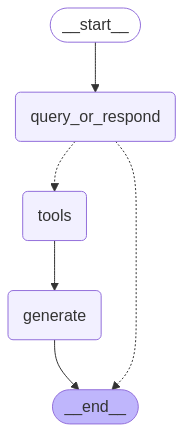

In [16]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

config = {"configurable": {"thread_id": "abc123"}}

In [18]:
input_message = "hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

hello


================================== Ai Message ==================================

Hello! How can I help you today?


In [19]:
input_message = "What caused free movement of goods in the EU?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What caused free movement of goods in the EU?


================================== Ai Message ==================================
Tool Calls:
  retrieve (d98e38fe-1ee7-4932-811e-e614c452e8d8)
 Call ID: d98e38fe-1ee7-4932-811e-e614c452e8d8
  Args:
    query: cause of free movement of goods in the EU


================================= Tool Message =================================
Name: retrieve

Source: {'start_index': 0, '_id': '52563be979064f56889e7110c0d63b51', '_collection_name': 'demo_collection'}
Content: Free movement of goods within the European Union is achieved by a customs union, and the principle of non-discrimination. The EU manages imports from non-member states, duties between member states are prohibited, and imports circulate freely. In addition under the Treaty on the Functioning of the European Union article 34, ‘Quantitative restrictions on imports and all measures having equivalent effect shall be prohibited between Member States’. In Procureur du Roi v Dassonville the Court of Justice held that this rule meant all "trading rules" that are "enacted by Member States" which could hinder trade "directly or indirectly, actually or potentially" would be caught by article 34. This meant that a Belgian law requiring Scotch whisky imports to have a certificate of origi

================================== Ai Message ==================================

Free movement of goods within the EU is achieved by a customs union and the principle of non-discrimination. The Treaty on the Functioning of the European Union articles 28 to 37 establish the principle of free movement of goods in the EU. Breaking down barriers to trade and enhancing free movement of goods is meant to reduce consumer prices.


## TODO 5: Monitor your agent in LangSmith.

If you have set up correctly, you can just visit the LangSmith website and see that your tracings are logged into your LangSmith project.

Capture your screen like this and upload it to MCV.

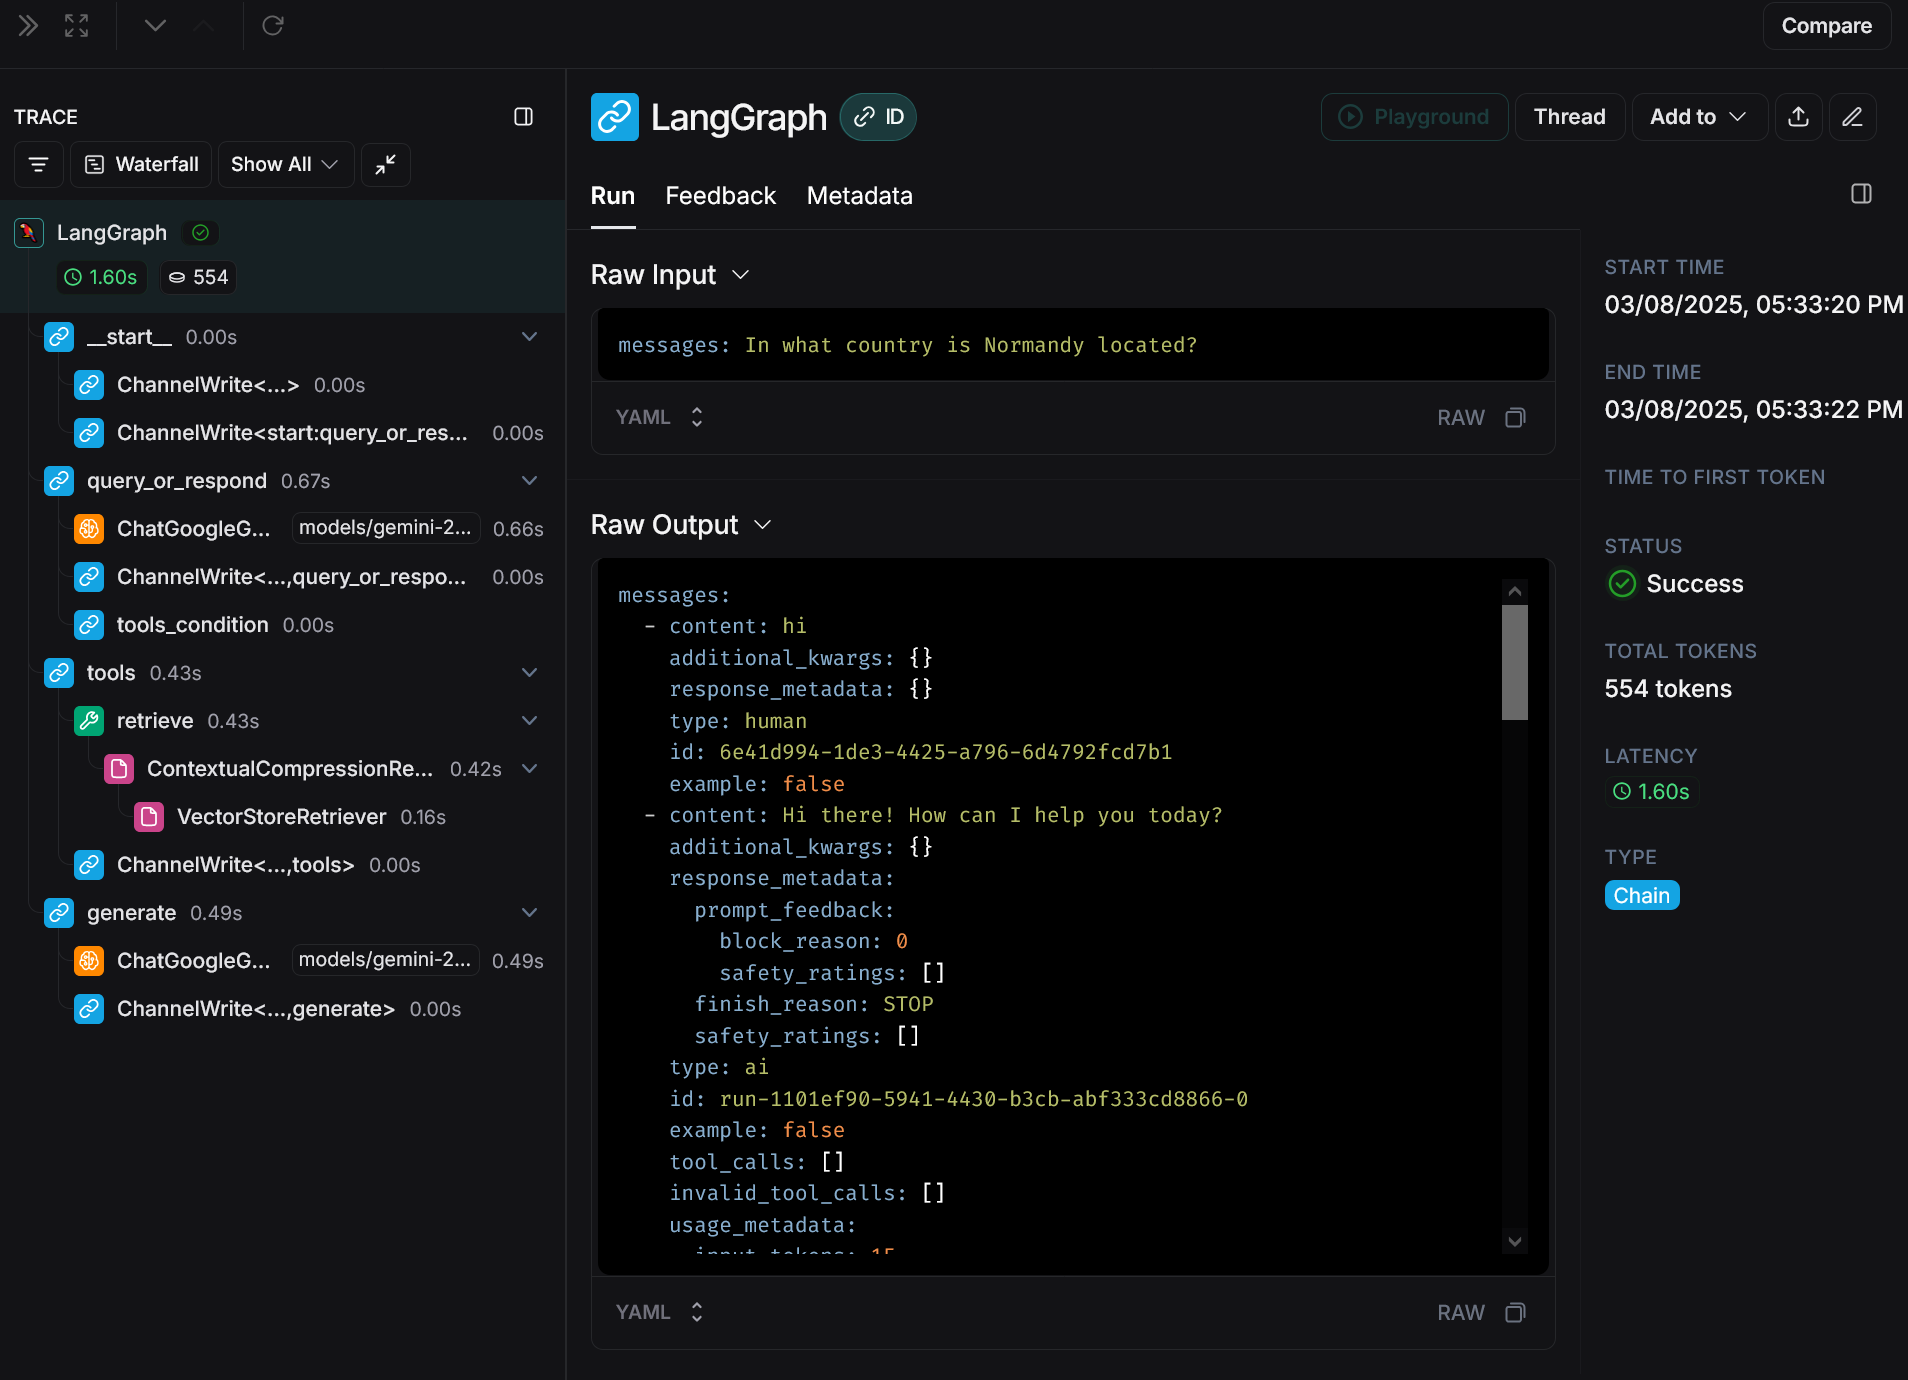

## Result

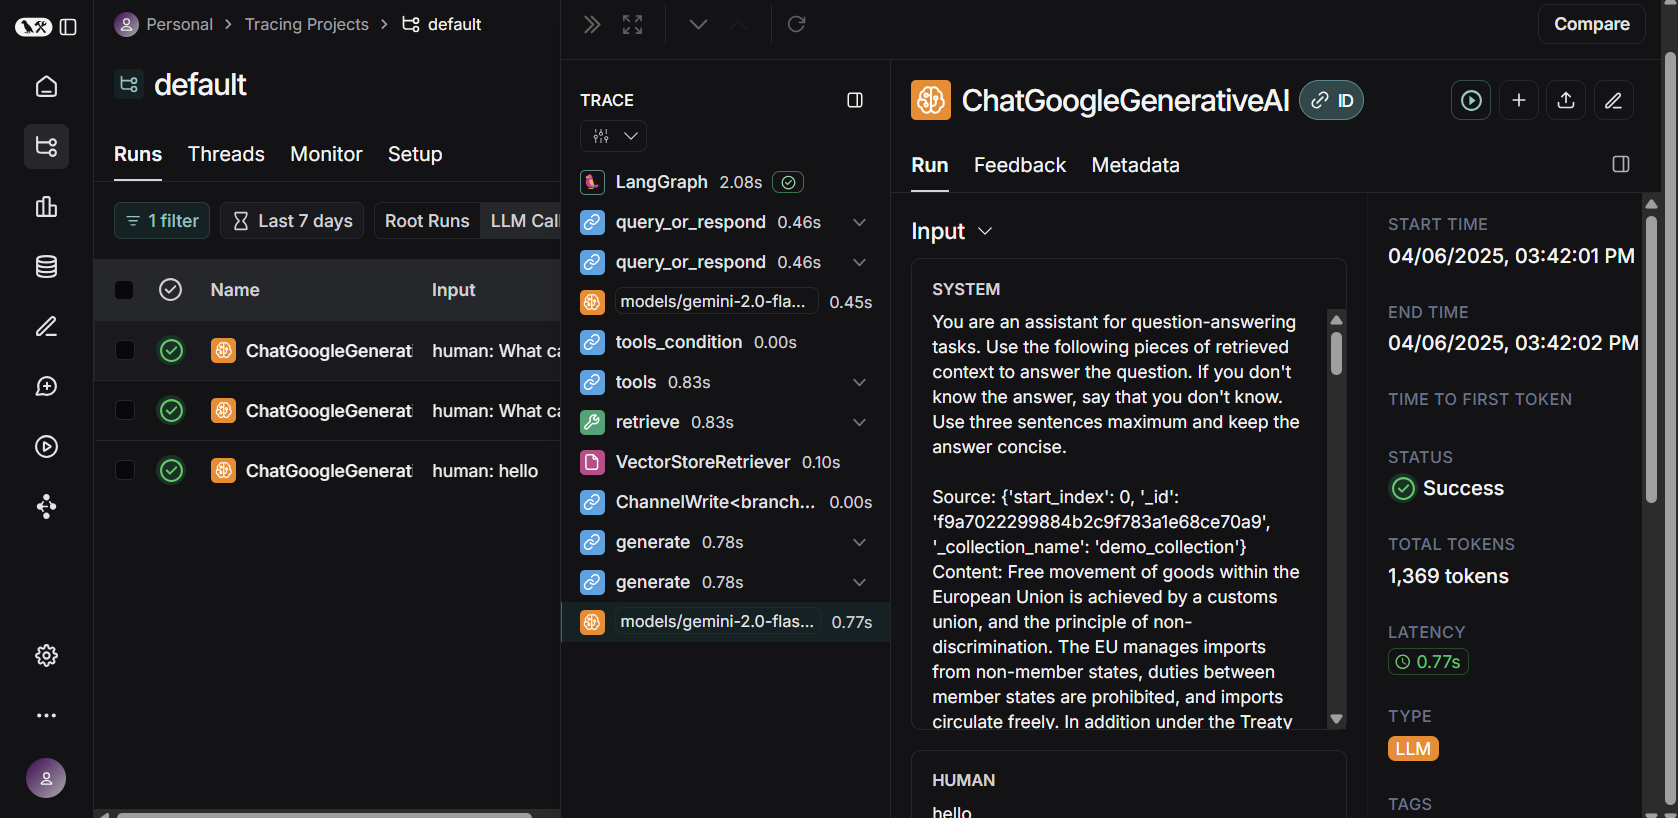